In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

In [2]:
from tqdm import tqdm
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from scipy.ndimage import zoom
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage.transform import resize, rotate
import random
import IPython

# Load LIDC dataset
### Step 1: Load all nodules as a 3D representation in numpy array & the labels from the nodule name

In [3]:
# Select an even number of slices to extract:
num_slices = 6
# Select nodules dataset location
lidc_path = Path('F:\\master\\LIDC\\nodules_16slices')

In [4]:
images = []
diagnostics = []
nodules_path = list(lidc_path.iterdir())
for nodule_path in nodules_path:
    images_path = list(nodule_path.iterdir())
    # Reduce the slices to the specified amount:
    images_path = images_path[int(len(images_path)/2)-int(num_slices/2):int(len(images_path)/2)+int(num_slices/2)]
    # Merge all slices of a nodule together --> create 3D representation of the nodule
    image_nodule = []
    for image_path in images_path:
        # Load slice image
        image_slice = np.array(Image.open(image_path)) / 255.0
        # Add it to the nodule
        image_nodule.append(image_slice)
    # convert the 3D nodule to numpy array
    image_nodule = np.array(image_nodule)
    
    diag = int(nodule_path.name.split('_')[5])
    # remove incorrect image shape or diagnostic incogruent
    if image_nodule.shape == (num_slices, 64, 64) and diag != 3:
        # Add the nodule 3D representation to the list of images
        images.append(image_nodule)
        # Save nodule label (diagnostic)
        diagnostics.append(diag)
    elif image_nodule.shape != (num_slices, 64, 64):
        print(f'[ERROR] {nodule_path.name} has shape {image_nodule.shape}, but expected shape is: (16, 64, 64)')
# convert the dataset to numpy array
images = np.array(images)

[ERROR] patient_462_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_463_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_655_nod_3_diag_2 has shape (6, 64, 57), but expected shape is: (16, 64, 64)
[ERROR] patient_997_nod_2_diag_1 has shape (6, 64, 55), but expected shape is: (16, 64, 64)


In [5]:
# Select an even number of slices to extract:
num_slices = 6
# Select nodules dataset location
path_50k = Path('F:\\master\\random_data\\50K_sample_1k_unique_slices')

In [6]:
images_50k = []
diagnostics_50k = []
nodules_path = list(path_50k.iterdir())
for nodule_path in nodules_path:
    images_path = list(nodule_path.iterdir())
    # Reduce the slices to the specified amount:
    images_path = images_path[int(len(images_path)/2)-int(num_slices/2):int(len(images_path)/2)+int(num_slices/2)]
    # Merge all slices of a nodule together --> create 3D representation of the nodule
    image_nodule = []
    for image_path in images_path:
        # Load slice image
        image_slice = np.array(Image.open(image_path)) / 255.0
        # Add it to the nodule
        image_nodule.append(image_slice)
    # convert the 3D nodule to numpy array
    image_nodule = np.array(image_nodule)
    
    diag = int(nodule_path.name.split('_')[5])
    # remove incorrect image shape or diagnostic incogruent
    if image_nodule.shape == (num_slices, 64, 64) and diag != 3:
        # Add the nodule 3D representation to the list of images
        images_50k.append(image_nodule)
        # Save nodule label (diagnostic)
        diagnostics_50k.append(diag)
    elif image_nodule.shape != (num_slices, 64, 64):
        print(f'[ERROR] {nodule_path.name} has shape {image_nodule.shape}, but expected shape is: (16, 64, 64)')
# convert the dataset to numpy array
images_50k = np.array(images_50k)

labels_50k = [0 if label<3 else 1 for label in diagnostics_50k]

#### Visualize data

In [7]:
from collections import Counter
import pandas

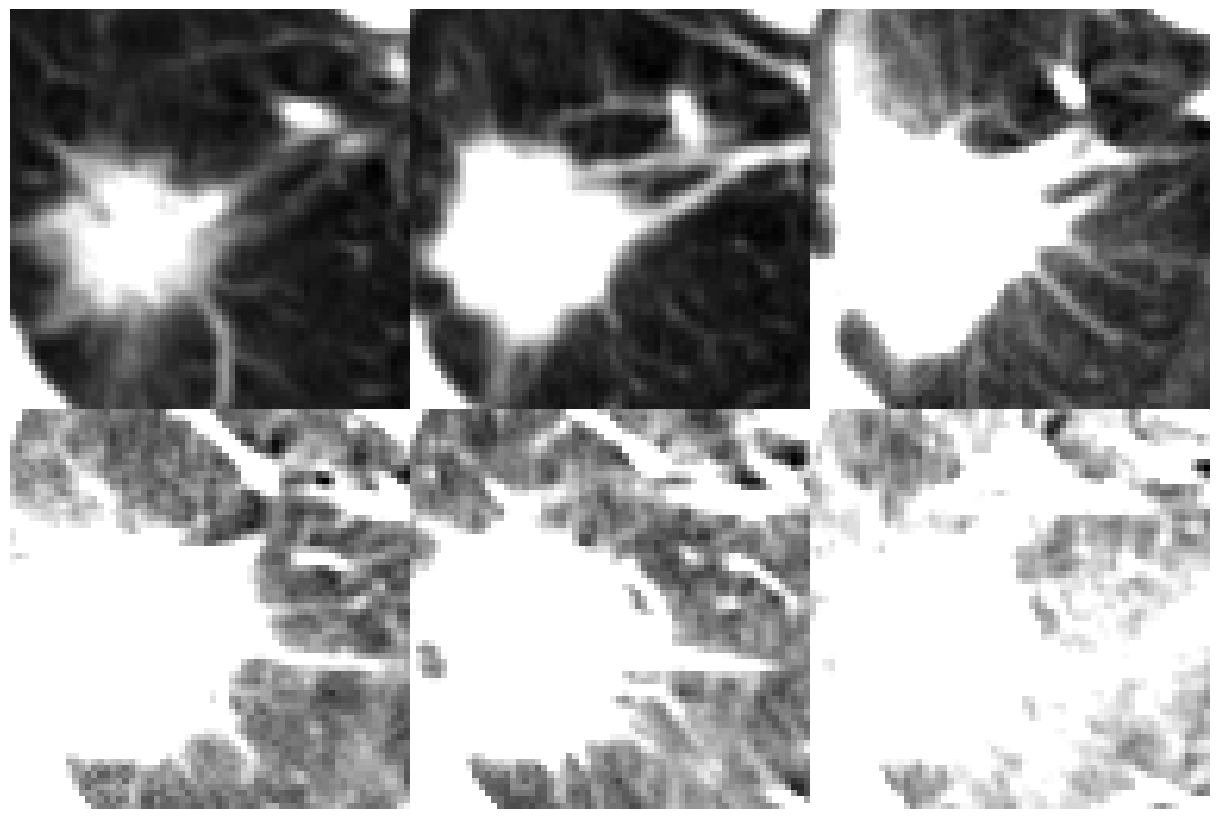

In [8]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of X CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i, j], cmap="gray")  # Corrected indexing
            #axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=images[0].transpose()
)

### Step 2: Simplify labels
The label is a subjective assessment of the likelihood of malignancy of the given nodule, assuming the scan originated from a 60-year-old male smoker.

The original label system has 5 labels:

1: ‘Highly Unlikely’

2: ‘Moderately Unlikely’

3: ‘Indeterminate’

4: ‘Moderately Suspicious’

5: ‘Highly Suspicious’

It has been simplified to a binary clasification system, being:

0: if original label < 3 (benign)

1: if original label > 3 (malign)

In [9]:
# Simplify label system
labels = [0 if label<3 else 1 for label in diagnostics]
labels = np.array(labels)

<Axes: >

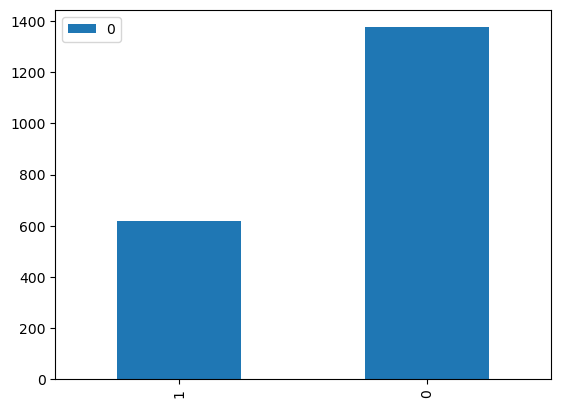

In [10]:
count = Counter(labels)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

# Data augmentation

Define function to rotate images

In [11]:
def rotate_image(image):
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    image = rotate(image.transpose(), angle).transpose()
    return image

Generate new images

In [12]:
images_aug = list(images)
labels_aug = list(labels)
for i, l in zip(images, labels):
    if l==1:
        for rep in range(3):
            images_aug.append(rotate_image(i))
            labels_aug.append(l)
    elif l==0:
        if 0.8 > random.random():
            images_aug.append(rotate_image(i))
            labels_aug.append(l)  

images_aug = np.array(images_aug)
labels_aug = np.array(labels_aug)

<Axes: >

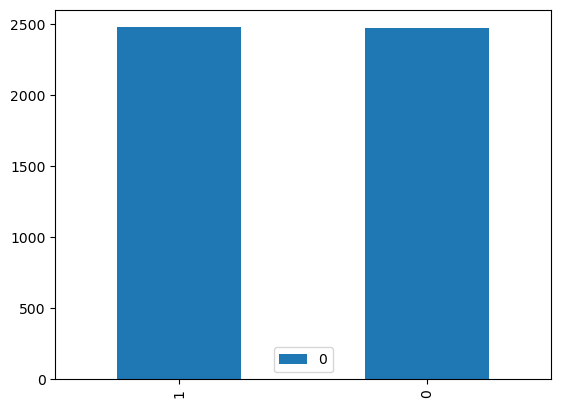

In [13]:
count = Counter(labels_aug)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

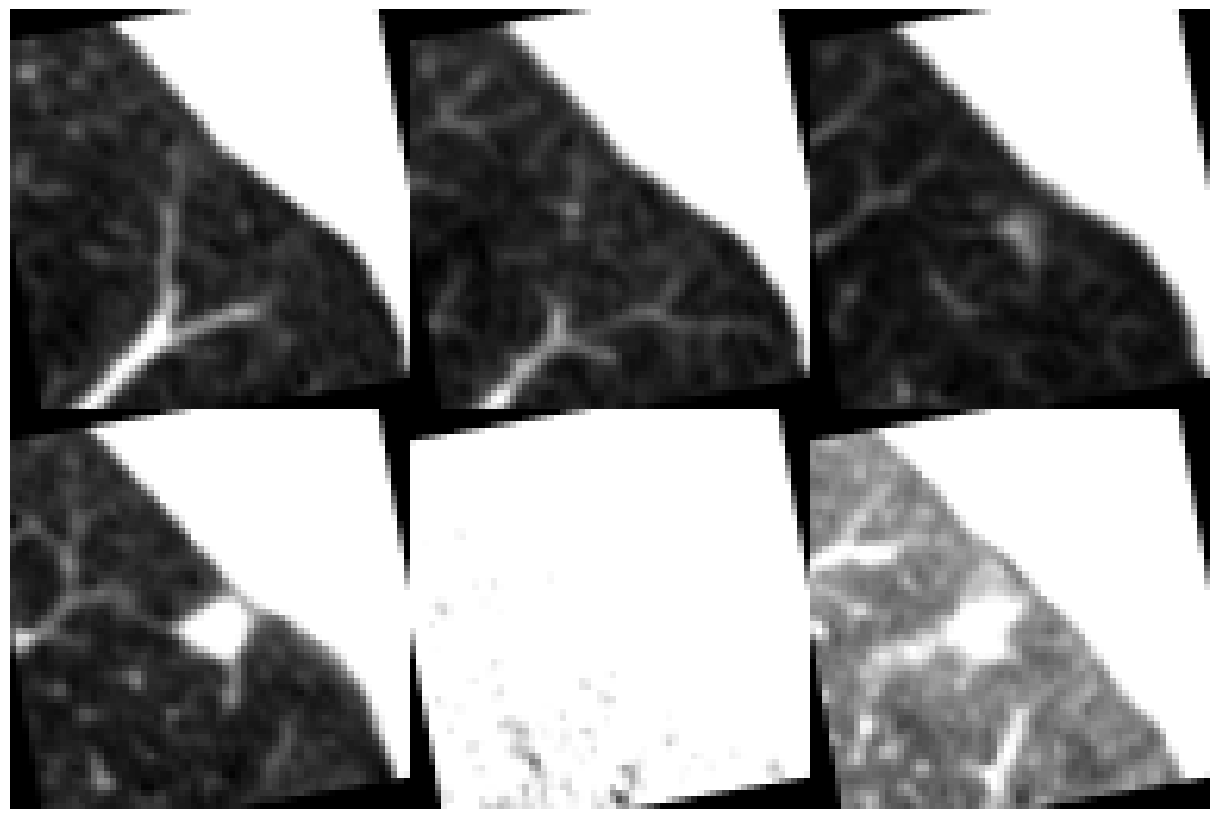

In [14]:
# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=images_aug[-1].transpose()
)

Divide between train and test data

In [15]:
# Create train and test dataset
train_images, test_images, train_labels, test_labels = train_test_split(images_aug, labels_aug, test_size=0.33, random_state=42)

# Building the CNN:
Models used by others: https://github.com/marichka-dobko/Lung_Nodule_Classification/blob/master/src_keras/models_keras.py

A simple CNN with 5 convolutional layers

In [16]:
def le_net_3d():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(2, 3, 3), activation='relu', padding='same', input_shape=(6,64,64,1)))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(2, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(strides=2)) 

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    return model


# Build model.
model = le_net_3d()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 6, 64, 64, 6)      114       
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 32, 32, 6)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 32, 32, 16)     1744      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 16, 16, 16)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 120)               


Epoch 1/12


C:\Users\pau_a\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(




104/104 [==============================] - 12s 89ms/step - loss: 0.6366 - accuracy: 0.6259 - val_loss: 0.5380 - val_accuracy: 0.7362
Epoch 2/12
104/104 [==============================] - 8s 80ms/step - loss: 0.5099 - accuracy: 0.7575 - val_loss: 0.4986 - val_accuracy: 0.7607
Epoch 3/12
104/104 [==============================] - 8s 80ms/step - loss: 0.4559 - accuracy: 0.7891 - val_loss: 0.4634 - val_accuracy: 0.7895
Epoch 4/12
104/104 [==============================] - 8s 78ms/step - loss: 0.4036 - accuracy: 0.8208 - val_loss: 0.4502 - val_accuracy: 0.7974
Epoch 5/12
104/104 [==============================] - 8s 79ms/step - loss: 0.3583 - accuracy: 0.8413 - val_loss: 0.4307 - val_accuracy: 0.8060
Epoch 6/12
104/104 [==============================] - 9s 86ms/step - loss: 0.2987 - accuracy: 0.8736 - val_loss: 0.4369 - val_accuracy: 0.8164
Epoch 7/12
104/104 [==============================] - 8s 81ms/step - loss: 0.2586 - accuracy: 0.8929 - val_loss: 0.4310 - val_accuracy: 0.8109
Epoch 8

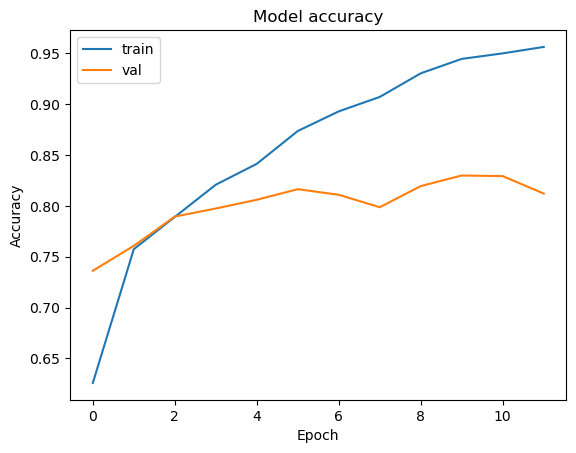

Training accuracy: 0.9562594294548035
Validation accuracy: 0.8121175169944763


In [17]:
def fit_model(model, epochs):  
    model.compile(  
        optimizer="adam",  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
        metrics=["accuracy"],  
    )  

    history = model.fit(  
        train_images,  
        train_labels,  
        epochs=epochs,  
        validation_data=(test_images, test_labels),  
    )
    
    # Plot training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # Plot final model accuracy
    print(f'Training accuracy: {history.history["accuracy"][-1]}')
    print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')
    return model


model = fit_model(model, epochs=12)

# Adding Dropout

Let’s see what a slightly different model would predict on these images. We’ll now use MC dropout as our model. By sampling, we should be able to increase the models’ uncertainty compared to a standard NN. 

Let’s first define our model:

In [18]:
def le_net_3d_dropout():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(2, 5, 5), activation='relu', padding='same', input_shape=(6,64,64,1)))
    
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(2, 5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(strides=2))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(84, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    return model

Then let’s instantiate it:

In [19]:
dropout_model = le_net_3d_dropout()
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 6, 64, 64, 6)      306       
                                                                 
 dropout (Dropout)           (None, 6, 64, 64, 6)      0         
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 3, 32, 32, 6)      0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 32, 32, 16)     4816      
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 1, 16, 16, 16)     0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 1, 16, 16, 16)    

Epoch 1/12
104/104 [==============================] - 25s 216ms/step - loss: 0.6430 - accuracy: 0.6196 - val_loss: 0.5481 - val_accuracy: 0.7381
Epoch 2/12
104/104 [==============================] - 22s 211ms/step - loss: 0.5471 - accuracy: 0.7357 - val_loss: 0.5052 - val_accuracy: 0.7540
Epoch 3/12
104/104 [==============================] - 22s 210ms/step - loss: 0.4945 - accuracy: 0.7566 - val_loss: 0.4969 - val_accuracy: 0.7638
Epoch 4/12
104/104 [==============================] - 22s 216ms/step - loss: 0.4766 - accuracy: 0.7716 - val_loss: 0.4600 - val_accuracy: 0.7858
Epoch 5/12
104/104 [==============================] - 25s 239ms/step - loss: 0.4391 - accuracy: 0.7964 - val_loss: 0.4532 - val_accuracy: 0.8035
Epoch 6/12
104/104 [==============================] - 23s 220ms/step - loss: 0.4124 - accuracy: 0.8124 - val_loss: 0.4374 - val_accuracy: 0.7950
Epoch 7/12
104/104 [==============================] - 22s 214ms/step - loss: 0.3691 - accuracy: 0.8326 - val_loss: 0.4070 - val_ac

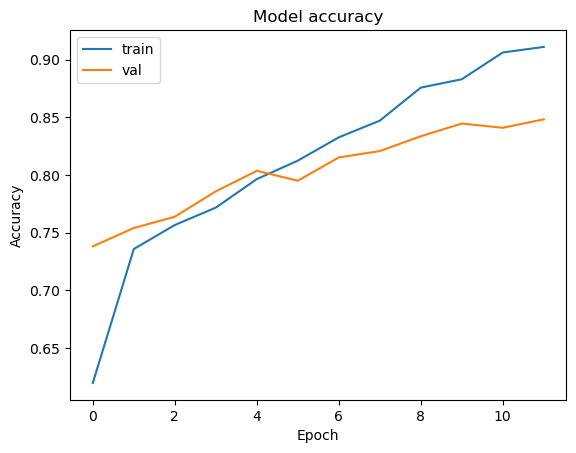

Training accuracy: 0.9110105633735657
Validation accuracy: 0.8482252359390259


In [20]:
dropout_model = fit_model(dropout_model, epochs=12)

Our model with dropout will achieve a similar accuracy as our vanilla model. Let’s now run inference with dropout and plot the mean confidence score of MC dropout:

In [21]:
def predictions_dropout(imgs):
    predictions = np.array(  
        [  
            tf.nn.softmax(dropout_model(np.expand_dims(imgs, -1), training=True), axis=1)  
            for _ in range(100)  
        ]  
    )  
    predictions_mean = np.mean(predictions, axis=0)
    return predictions_mean

# Define models evaluation method

In [22]:
class ModelEvaluation:
    def __init__(self, model, test_images, test_labels, dropout_inference=False):
        self.pred_dict = {'correct':[], 'incorrect': []}
        self.pred_prob_dict = {'correct':[], 'incorrect': []}
        self.pred_std_dict = {'correct':[], 'incorrect': []}
        self.pred_prob_std_dict = {'correct':[], 'incorrect': []}
        self.model_accuracy = None

        for test_image, test_label in tqdm(zip(test_images, test_labels)):
            if dropout_inference:
                self.update_dropout_pred_dict(image=test_image, label=test_label, model=model)
            else:
                self.update_classic_pred_dict(image=test_image, label=test_label, model=model)

    def update_dropout_pred_dict(self, model, image, label):
        
        # Simulate Bayesian CNN with dropout at inference (100 test runs)
        pred_list = [  
            dropout_model(np.expand_dims([image], -1), training=True) 
            for _ in range(100)  
        ]
        pred = np.mean(np.array(pred_list), axis=0)
        
        # Compute standard deviation of prediction 
        pred_std_list = [  
            np.argmax(np.array(p[0]))
            for p in pred_list 
        ]
        pred_std = np.std(np.array(pred_std_list), dtype=np.float64)
        
        # Compute standard deviation of prediction confidence
        pred_prob_std_list = [  
            np.array(p[0]).max() * 100
            for p in pred_list 
        ]
        pred_prob_std = np.std(np.array(pred_prob_std_list), dtype=np.float64)
        
        
        # Compute the top predicted class probability
        pred_conf = pred[0].max() 
        pred_conf = int(round(pred_conf*100, 2))
        # Compute the top predicted class
        pred_label = np.argmax(pred[0])
        # Check if the prediction is correct
        pred_correct = pred_label==label
        # Update dictionary
        self.update_pred_dict(pred_correct, pred_label)
        self.update_pred_prob_dict(pred_correct, pred_conf)
        self.update_pred_std_dict(pred_correct, pred_std)
        self.update_pred_prob_std_dict(pred_correct, pred_prob_std)
    
    def update_classic_pred_dict(self, model, image, label):
        
        pred = model.predict(np.expand_dims([image], -1), verbose=0)
        # Get the index of the class with the highest probability
        pred_label = np.argmax(pred)
        # Compute the top predicted class probability
        pred_conf = pred[0][pred_label]
        pred_conf = int(round(pred_conf*100, 2))
        
        # Check if the prediction is correct
        pred_correct = pred_label==label
        
        self.update_pred_dict(pred_correct, pred_label)
        self.update_pred_prob_dict(pred_correct, pred_conf)
    
    def update_pred_dict(self, pred_correct, pred_conf):
        # Update dictionary
        if pred_correct:
            self.pred_dict['correct'].append(pred_conf)
        else:
            self.pred_dict['incorrect'].append(pred_conf)
            
    def update_pred_prob_dict(self, pred_correct, pred_conf):
        # Update dictionary
        if pred_correct:
            self.pred_prob_dict['correct'].append(pred_conf)
        else:
            self.pred_prob_dict['incorrect'].append(pred_conf)
            
    def update_pred_std_dict(self, pred_correct, pred_std):
        # Update dictionary
        if pred_correct:
            self.pred_std_dict['correct'].append(pred_std)
        else:
            self.pred_std_dict['incorrect'].append(pred_std)
            
    def update_pred_prob_std_dict(self, pred_correct, pred_prob_std):
        # Update dictionary
        if pred_correct:
            self.pred_prob_std_dict['correct'].append(pred_prob_std)
        else:
            self.pred_prob_std_dict['incorrect'].append(pred_prob_std)
    
    def plot_pred_dist(self, num_bins=25):
        plt.figure(figsize=(15, 5))
        # Plot probability histogram
        bins = np.linspace(50, 100, num_bins)

        # Correct predictions probability distribution
        plt.hist(
            self.pred_prob_dict['correct'],
            bins,
            weights=np.ones(len(self.pred_prob_dict['correct'])) / len(self.pred_prob_dict['correct']),
            alpha=0.5,
            label='correct',
            color='g',
        )
        # Incorrect predictions probability distribution
        plt.hist(
            self.pred_prob_dict['incorrect'],
            bins,
            weights=np.ones(len(self.pred_prob_dict['incorrect'])) / len(self.pred_prob_dict['incorrect']),
            alpha=0.5,
            label='incorrect',
            color='r',
        )
        # Add correct predictions mean probability
        plt.axvline(x=np.mean(self.pred_prob_dict['correct']), color='g', label=f'Correct predictions - mean probability - {np.mean(self.pred_prob_dict["correct"])}')
        # Add incorrect predictions mean probability
        plt.axvline(x=np.mean(self.pred_prob_dict['incorrect']), color='r', label=f'Incorrect predictions - mean probability - {np.mean(self.pred_prob_dict["incorrect"])}')
        # Add model accuracy
        plt.axvline(x=self.get_model_accuracy(), color='b', label=f'Model accuracy - {self.get_model_accuracy()}')
        # Format y axis as a percentage (example: from 0.8 to 80%)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Add legend
        plt.legend(loc='upper right')
        plt.title('Prediction probability distribution')
        plt.xlabel('Prediction probability (%)')
        plt.ylabel('Distribution')
        plt.show()
        plt.close()
    
    def plot_pred_dist_wo_jdg(self, num_bins=25):
        pred_list = []
        pred_list.extend(self.pred_prob_dict['correct'])
        pred_list.extend(self.pred_prob_dict['incorrect'])
        pred_list = np.array(pred_list)
        
        plt.figure(figsize=(15, 5))
        # Plot probability histogram
        bins = np.linspace(50, 100, num_bins)

        # All predictions probability distribution
        plt.hist(
            pred_list,
            bins,
            weights=np.ones(len(pred_list)) / len(pred_list),
            label='All',
            color='blue',
        )

        # Add correct predictions mean probability
        plt.axvline(x=np.mean(pred_list), color='black', label=f'All predictions - mean probability - {np.mean(pred_list)}')
        # Add model accuracy
        plt.axvline(x=self.get_model_accuracy(), color='g', label=f'Model accuracy - {self.get_model_accuracy()}')
        # Format y axis as a percentage (example: from 0.8 to 80%)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Add legend
        plt.legend(loc='upper right')
        plt.title('Prediction probability distribution')
        plt.xlabel('Prediction probability (%)')
        plt.ylabel('Distribution')
        plt.show()
        plt.close()
        
    def plot_pred_prob_std_dist(self, max_value=20, num_bins=100):
        plt.figure(figsize=(15, 5))
        # Plot probability histogram
        bins = np.linspace(0, max_value, num_bins)
        # Correct predictions probability distribution
        plt.hist(
            self.pred_prob_std_dict['correct'],
            weights=np.ones(len(self.pred_prob_std_dict['correct'])) / len(self.pred_prob_std_dict['correct']),
            alpha=0.5,
            label='correct',
            color='g',
            bins=bins,
        )
        # Incorrect predictions probability distribution
        plt.hist(
            self.pred_prob_std_dict['incorrect'],
            weights=np.ones(len(self.pred_prob_std_dict['incorrect'])) / len(self.pred_prob_std_dict['incorrect']),
            alpha=0.5,
            label='incorrect',
            color='r',
            bins=bins,
        )
        # Add correct predictions mean probability
        plt.axvline(x=np.mean(self.pred_prob_std_dict['correct']), color='g', label=f'Correct predictions - prediction probability std - {np.mean(self.pred_prob_std_dict["correct"])}')
        # Add incorrect predictions mean probability
        plt.axvline(x=np.mean(self.pred_prob_std_dict['incorrect']), color='r', label=f'Incorrect predictions - prediction probability std - {np.mean(self.pred_prob_std_dict["incorrect"])}')
        # Format y axis as a percentage (example: from 0.8 to 80%)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Add legend
        plt.legend(loc='upper right')
        plt.title('Prediction probability standard deviation distribution')
        plt.xlabel('Prediction probability standard deviation')
        plt.ylabel('Distribution')
        plt.show()
        plt.close()
    
    def plot_pred_prob_std_dist_wo_jdg(self, max_value=20, num_bins=100):
        pred_list = []
        pred_list.extend(self.pred_prob_std_dict['correct'])
        pred_list.extend(self.pred_prob_std_dict['incorrect'])
        pred_list = np.array(pred_list)
        
        plt.figure(figsize=(15, 5))
        # Plot probability histogram
        bins = np.linspace(0, max_value, num_bins)
        # All correct predictions probability distribution
        plt.hist(
            pred_list,
            weights=np.ones(len(pred_list)) / len(pred_list),
            label='All',
            color='blue',
            bins=bins,
        )
        # Add mean
        plt.axvline(x=np.mean(pred_list), color='black', label=f'All predictions - prediction probability std - {np.mean(pred_list)}')
        # Format y axis as a percentage (example: from 0.8 to 80%)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Add legend
        plt.legend(loc='upper right')
        plt.title('Prediction probability standard deviation distribution')
        plt.xlabel('Prediction probability standard deviation')
        plt.ylabel('Distribution')
        plt.show()
        plt.close()
    
    def plot_pred_std_dist(self, num_bins=100):
        plt.figure(figsize=(15, 5))
        # Plot probability histogram
        bins = np.linspace(0, 1, num_bins)
        # Correct predictions probability distribution
        plt.hist(
            self.pred_std_dict['correct'],
            weights=np.ones(len(self.pred_std_dict['correct'])) / len(self.pred_std_dict['correct']),
            alpha=0.5,
            label='correct',
            color='g',
            bins=bins,
        )
        # Incorrect predictions probability distribution
        plt.hist(
            self.pred_std_dict['incorrect'],
            weights=np.ones(len(self.pred_std_dict['incorrect'])) / len(self.pred_std_dict['incorrect']),
            alpha=0.5,
            label='incorrect',
            color='r',
            bins=bins,
        )
        # Add correct predictions mean probability
        plt.axvline(x=np.mean(self.pred_std_dict['correct']), color='g', label=f'Correct predictions - prediction label std - {np.mean(self.pred_std_dict["correct"])}')
        # Add incorrect predictions mean probability
        plt.axvline(x=np.mean(self.pred_std_dict['incorrect']), color='r', label=f'Incorrect predictions - prediction label std - {np.mean(self.pred_std_dict["incorrect"])}')
        # Format y axis as a percentage (example: from 0.8 to 80%)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Add legend
        plt.legend(loc='upper right')
        plt.title('Prediction standard deviation distribution')
        plt.xlabel('Prediction label standard deviation')
        plt.ylabel('Distribution')
        plt.show()
        plt.close()
    
    def plot_pred_std_dist_wo_jdg(self, num_bins=100):
        pred_list = []
        pred_list.extend(self.pred_std_dict['correct'])
        pred_list.extend(self.pred_std_dict['incorrect'])
        pred_list = np.array(pred_list)
        
        plt.figure(figsize=(15, 5))
        # Plot probability histogram
        bins = np.linspace(0, 1, num_bins)
        # All predictions probability distribution
        plt.hist(
            pred_list,
            weights=np.ones(len(pred_list)) / len(pred_list),
            label='All',
            color='blue',
            bins=bins,
        )
        # Add correct predictions mean probability
        plt.axvline(x=np.mean(pred_list), color='black', label=f'All predictions - prediction label std - {np.mean(pred_list)}')
        # Format y axis as a percentage (example: from 0.8 to 80%)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Add legend
        plt.legend(loc='upper right')
        plt.title('Prediction standard deviation distribution')
        plt.xlabel('Prediction label standard deviation')
        plt.ylabel('Distribution')
        plt.show()
        plt.close()
    
    @staticmethod
    def polyfit(x, y):
        a, b, c, d, e, f = np.polyfit(x, y, 5)
        fit_equation = lambda x: a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f
        x_fit = np.linspace(min(x), max(x), 1000)
        y_fit = fit_equation(x_fit)

        return x_fit, y_fit

    def plot_scatter(self):
        plt.figure(figsize=(10, 10))
        # Set axis range (Xmin, Xmax, Ymin, Ymax)
        plt.axis([50, 100, 0, 50])
        
        # Extract x and y coordinates from dictionaries
        x_correct = self.pred_prob_dict['correct']
        y_correct = self.pred_prob_std_dict['correct']

        # Create scatter plot
        plt.scatter(x_correct, y_correct, alpha=0.8, c='lightgreen', label='Correct')

        # Add polyfit line
        x_fit, y_fit = self.polyfit(x_correct, y_correct)
        plt.plot(x_fit, y_fit, color='g', label='Correct - 5th order polyfit')

        # Extract x and y coordinates from dictionaries
        x_incorrect = self.pred_prob_dict['incorrect']
        y_incorrect = self.pred_prob_std_dict['incorrect']

        # Create scatter plot
        plt.scatter(x_incorrect, y_incorrect, alpha=0.8, c='lightcoral', label='Incorrect')

        # Add polyfit line
        x_fit, y_fit = self.polyfit(x_incorrect, y_incorrect)
        plt.plot(x_fit, y_fit, color='r',label='Incorrect - 5th order polyfit')

        # Add labels and legend
        plt.xlabel('Prediction probability - mean')
        plt.ylabel('Prediction probability - standard deviation')
        plt.legend()

        # Show plot
        plt.show()
        

    def get_pred_prob_dict(self):
        return self.pred_prob_dict
    
    def get_pred_dict(self):
        return self.pred_dict
    
    def get_pred_prob_std_dict(self):
        return self.pred_prob_std_dict
    
    def get_pred_std_dict(self):
        return self.pred_std_dict
    
    def get_model_accuracy(self):
        num_pred_co = len(self.pred_prob_dict['correct'])
        num_pred_in = len(self.pred_prob_dict['incorrect'])
        return (num_pred_co / (num_pred_co + num_pred_in)) * 100

## Traditional CNN evaluation

In [23]:
me_classic = ModelEvaluation(model, test_images, test_labels, dropout_inference=False)

pred_prob_dict = me_classic.get_pred_prob_dict()
print(f'Mean correct prediction probabilities: {np.mean(pred_prob_dict["correct"])}')
print(f'Mean incorrect prediction probabilities: {np.mean(pred_prob_dict["incorrect"])}')
print(f'Model accuracy: {me_classic.get_model_accuracy()}')

1634it [02:12, 12.33it/s]

Mean correct prediction probabilities: 92.25018839487566
Mean incorrect prediction probabilities: 78.98045602605863
Model accuracy: 81.21175030599755


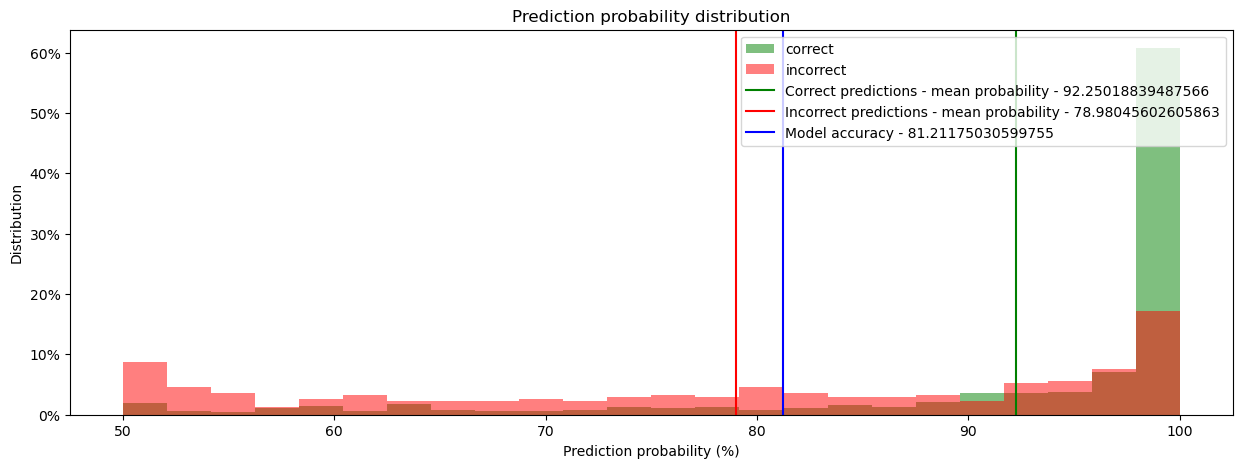

In [24]:
me_classic.plot_pred_dist()

In [25]:
me_classic_50k = ModelEvaluation(model, images_50k, labels_50k, dropout_inference=False)

1000it [01:16, 13.15it/s]


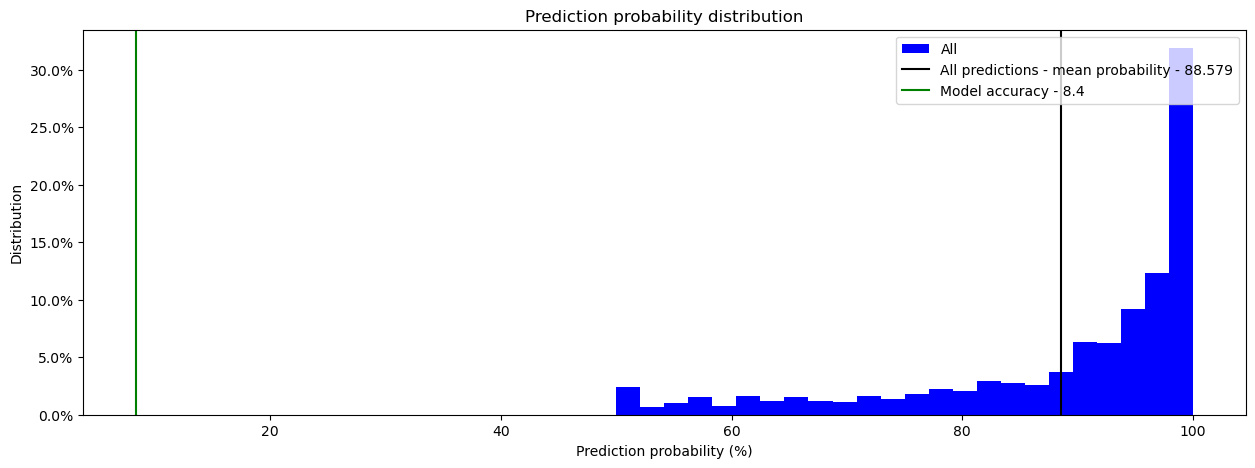

In [26]:
# Print distribution
me_classic_50k.plot_pred_dist_wo_jdg()

## Dropout (training only) model evaluation


1634it [02:10, 12.55it/s]


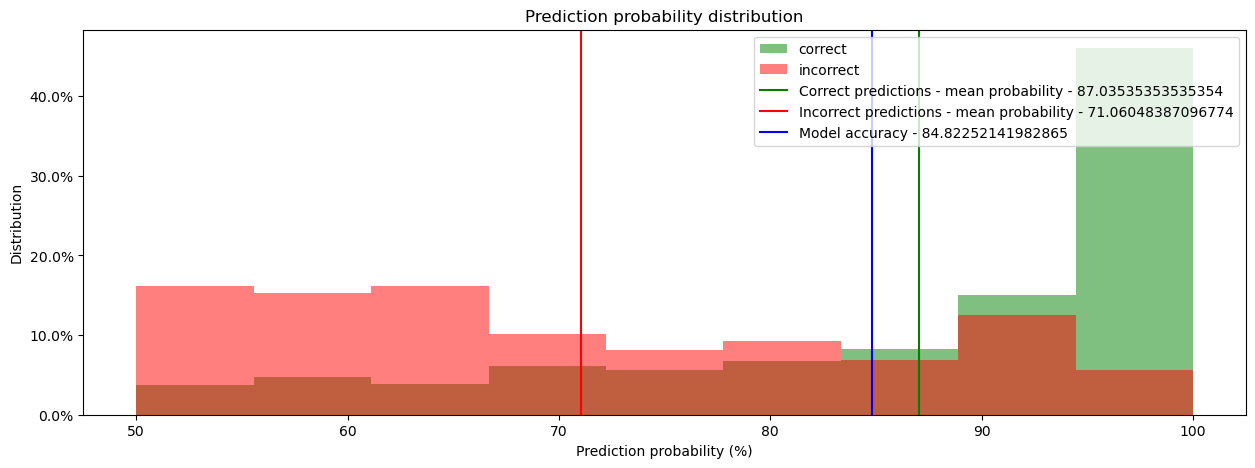

In [27]:
me_drop = ModelEvaluation(dropout_model, test_images, test_labels, dropout_inference=False)

me_drop.plot_pred_dist(num_bins=10)

In [28]:
me_drop_50k = ModelEvaluation(dropout_model, images_50k, labels_50k, dropout_inference=False)

1000it [04:07,  4.03it/s]


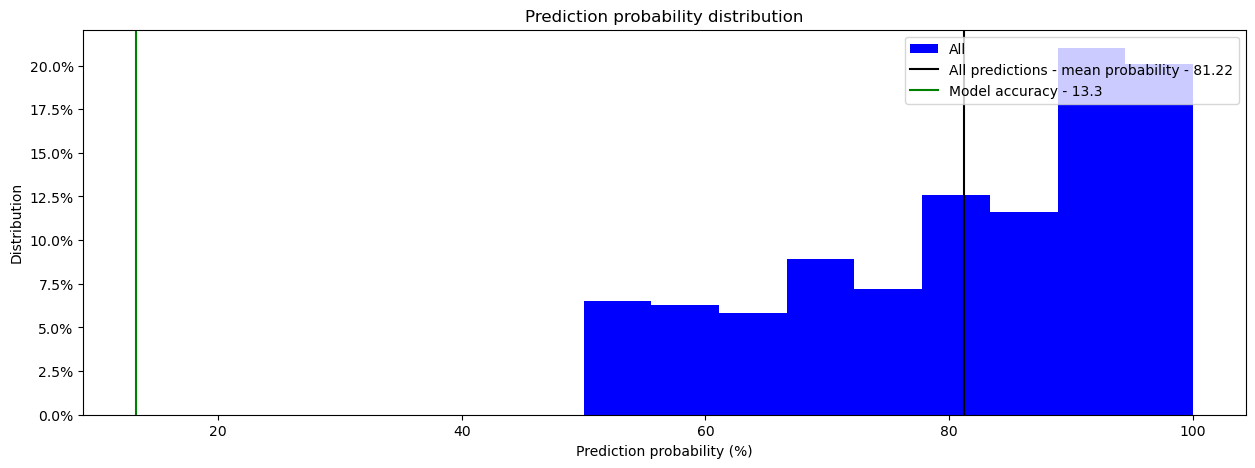

In [29]:
me_drop_50k.plot_pred_dist_wo_jdg(num_bins=10)

## Bayesian (dropout @ training & inference) model evaluation

Step 1: make inference in all test dataset

In [30]:
me_bayesian = ModelEvaluation(dropout_model, test_images, test_labels, dropout_inference=True)

1634it [42:45,  1.57s/it]


Step 2: visualize results

70.29083665338645


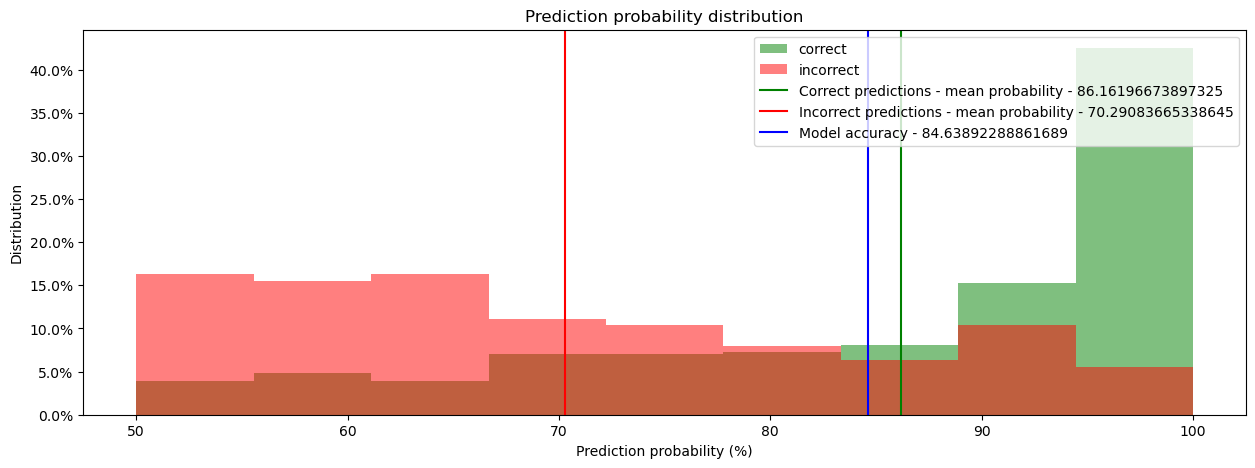

In [31]:
print(np.mean(me_bayesian.pred_prob_dict['incorrect']))
me_bayesian.plot_pred_dist(num_bins=10)

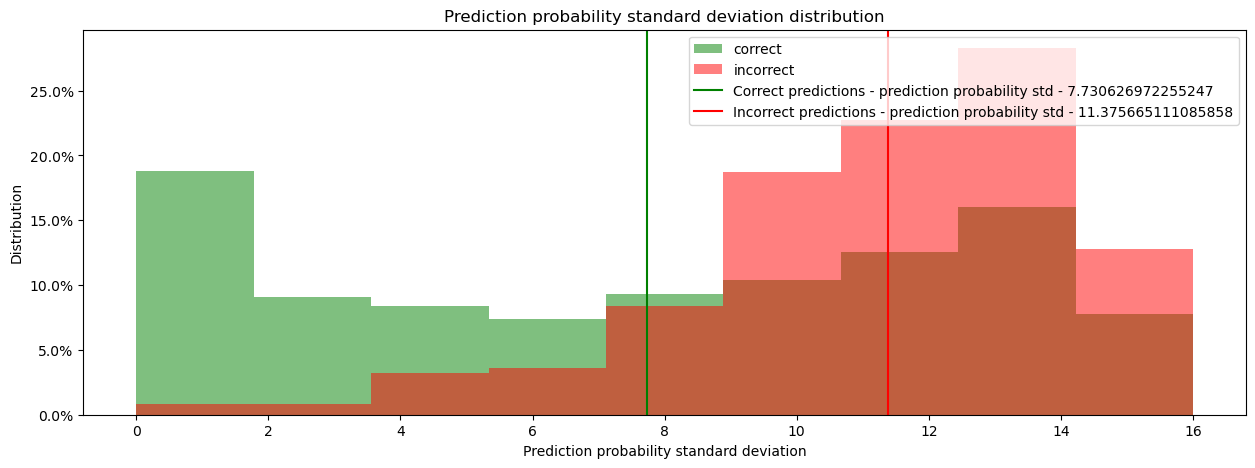

In [32]:
me_bayesian.plot_pred_prob_std_dist(max_value=16, num_bins=10)

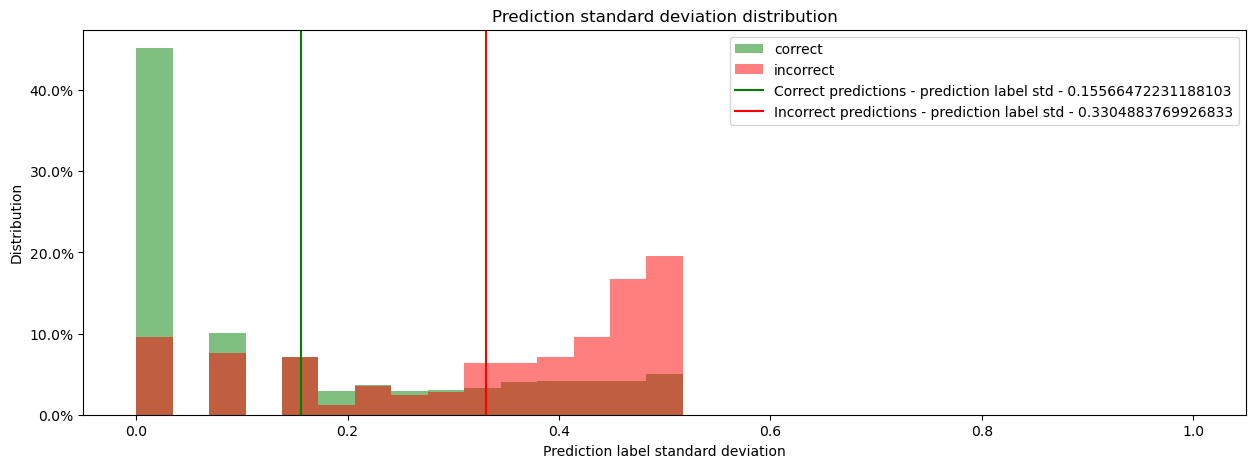

In [57]:
me_bayesian.plot_pred_std_dist(num_bins=30)

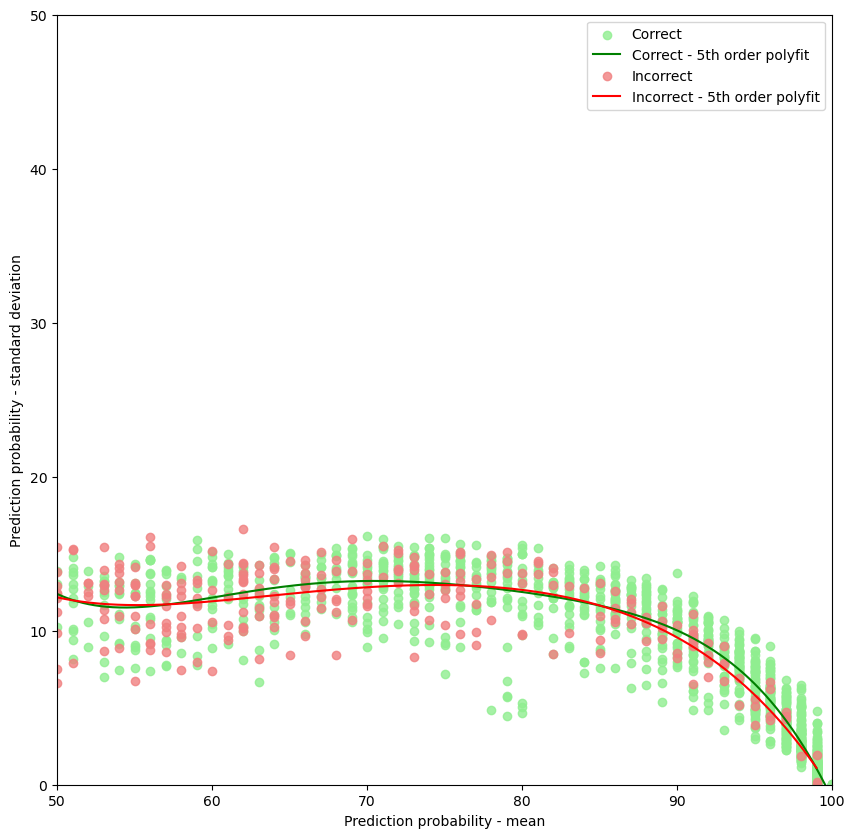

In [34]:
me_bayesian.plot_scatter()

In [35]:
me_bayesian_50k = ModelEvaluation(dropout_model, images_50k, labels_50k, dropout_inference=True)

1000it [26:15,  1.58s/it]


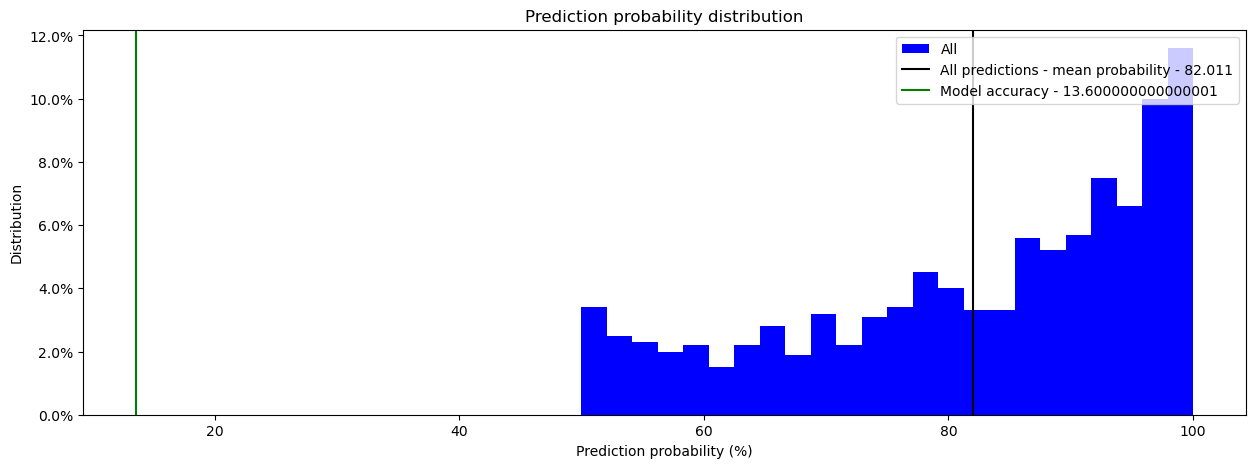

In [36]:
me_bayesian_50k.plot_pred_dist_wo_jdg()

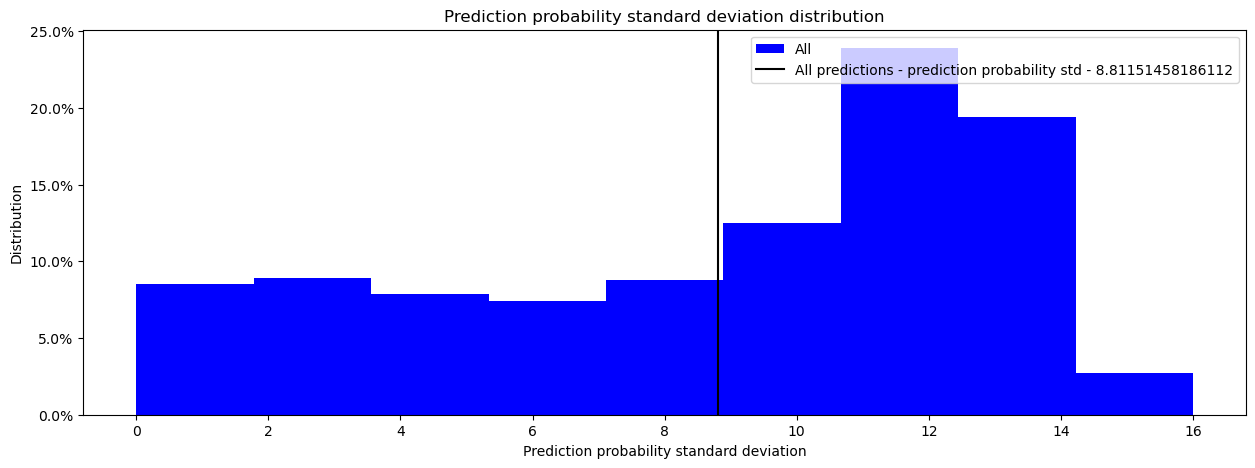

In [37]:
me_bayesian_50k.plot_pred_prob_std_dist_wo_jdg(max_value=16, num_bins=10)

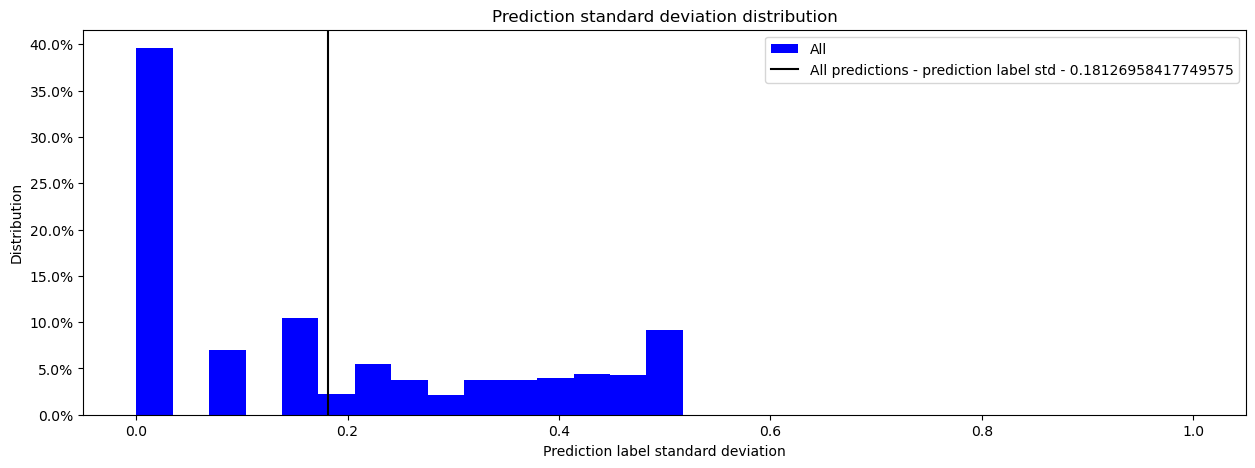

In [38]:
me_bayesian_50k.plot_pred_std_dist_wo_jdg(num_bins=30)

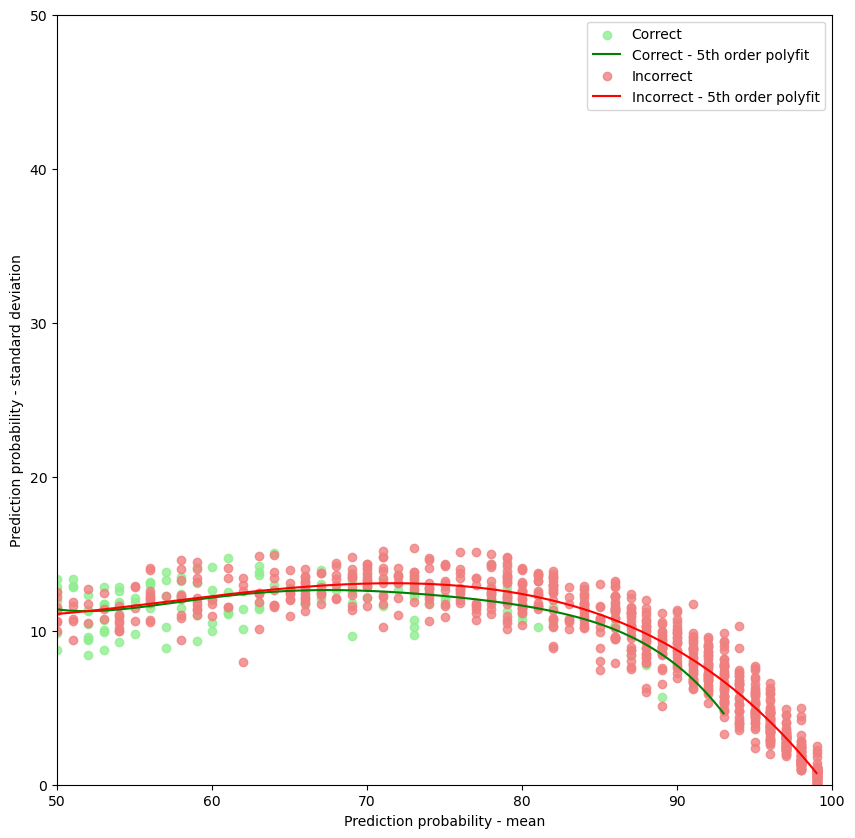

In [39]:
me_bayesian_50k.plot_scatter()

# GRAD-CAM heatmap

In [40]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap

def display_gradcam(img, heatmap, alpha=0.4):
    fig, ax = plt.subplots(1, 2, figsize=(10, 20))

    ax[0].imshow(np.squeeze(img), cmap='gray')
    img0 = ax[1].imshow(np.squeeze(img), cmap='gray')
    img1 = ax[1].imshow(np.squeeze(heatmap), cmap='jet', alpha=alpha, extent=img0.get_extent())
    plt.show()

#### Display gradcam for the traditional CNN

In [41]:
def compute_gradcam(img, label, display=True, alpha=0.4):
    # Prepare image
    img_array = img
    #print(f'Original image shape: {img_array.shape}')
    img_array = np.expand_dims(img_array, -1)
    img_array = np.expand_dims(img_array, 0)
    #print(f'Reshaped image shape: {img_array.shape}')

    # Remove last layer's softmax
    model.layers[-1].activation = None

    if display:
        # Print what the top predicted class is
        softmax_predictions = tf.nn.softmax(model(np.expand_dims([img], -1)), axis=1)
        pred_conf = softmax_predictions[0].numpy().max()  
        pred_label = np.argmax(softmax_predictions[0])
        print(f'Prediction: {pred_label} - {round(pred_conf*100, 2)}%')
        print(f'Ground truth: {label}')

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv3d_1')

    # Resize headmap from convolution layer shape to original image shape
    heatmap_upscaled = get_resized_heatmap(heatmap, shape=test_images[10].shape)

    # Superpose heatmap to middle image
    img_plot = np.expand_dims(img, -1)
    if display:
        #print(f'Image to plot shape: {img_plot.shape}')
        display_gradcam(img_plot[2, :, :], heatmap_upscaled[2, :, :], alpha=alpha)
    else:
        return heatmap_upscaled, img_plot

Display gradcam for the Dropout CNN

In [42]:
def compute_gradcam_dropout(img, label, display=True, alpha=0.4):
    # Prepare image
    img_array = img
    #print(f'Original image shape: {img_array.shape}')
    img_array = np.expand_dims(img_array, -1)
    img_array = np.expand_dims(img_array, 0)
    #print(f'Reshaped image shape: {img_array.shape}')

    # Remove last layer's softmax
    dropout_model.layers[-1].activation = None

    if display:
        # Print what the top predicted class is
        softmax_predictions_drop_out = predictions_dropout([img])
        #softmax_predictions = tf.nn.softmax(model(np.expand_dims([test_images[10]], -1)), axis=1)
        pred_conf = softmax_predictions_drop_out[0].max()  
        pred_label = np.argmax(softmax_predictions_drop_out[0])
        print(f'Prediction: {pred_label} - {round(pred_conf*100, 2)}%')
        print(f'Ground truth: {label}')

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, dropout_model, last_conv_layer_name='conv3d_3')

    # Resize headmap from convolution layer shape to original image shape
    heatmap_upscaled = get_resized_heatmap(heatmap, shape=img.shape)

    # Superpose heatmap to middle image
    img_plot = np.expand_dims(img, -1)
    if display:
        #print(f'Image to plot shape: {img_plot.shape}')
        display_gradcam(img_plot[2, :, :], heatmap_upscaled[2, :, :], alpha=alpha)
    else:
        return heatmap_upscaled, img_plot

Display gradcam for the Bayesian CNN

In [43]:
def compute_gradcam_bayesian(img, label, display=True, alpha=0.4):
    # Prepare image
    img_array = img
    #print(f'Original image shape: {img_array.shape}')
    img_array = np.expand_dims(img_array, -1)
    img_array = np.expand_dims(img_array, 0)
    #print(f'Reshaped image shape: {img_array.shape}')

    # Remove last layer's softmax
    dropout_model.layers[-1].activation = None

    # Simulate Bayesian CNN with dropout at inference (100 test runs)
    pred_list = [
        tf.nn.softmax(dropout_model(np.expand_dims([img], -1), training=True), axis=1)  
        for _ in range(100)  
    ]
    pred = np.mean(np.array(pred_list), axis=0)

    # Compute standard deviation of prediction 
    pred_std_list = [  
        np.argmax(np.array(p[0]))
        for p in pred_list 
    ]
    pred_std = np.std(np.array(pred_std_list), dtype=np.float64)

    # Compute standard deviation of prediction confidence
    pred_prob_std_list = [  
        np.array(p[0]).max() * 100
        for p in pred_list 
    ]
    pred_prob_std = np.std(np.array(pred_prob_std_list), dtype=np.float64)

    # Compute the top predicted class probability
    pred_conf = pred[0].max()
    # Compute the top predicted class
    pred_label = np.argmax(pred[0])
    # Check if the prediction is correct
    pred_correct = pred_label==label
    
    if display:
        print(f'Prediction: {pred_label} - {round(pred_conf*100, 2)}%')
        print(f'Std dev: {round(pred_std, 2)} - {round(pred_prob_std, 2)}%')
        print(f'Prediction correct: {pred_correct}')

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, dropout_model, last_conv_layer_name='conv3d_3')

    # Resize headmap from convolution layer shape to original image shape
    heatmap_upscaled = get_resized_heatmap(heatmap, shape=img.shape)

    # Superpose heatmap to middle image
    img_plot = np.expand_dims(img, -1)
    if display:
        #print(f'Image to plot shape: {img_plot.shape}')
        display_gradcam(img_plot[2, :, :], heatmap_upscaled[2, :, :], alpha=alpha)
    else:
        return heatmap_upscaled, img_plot, pred_label, pred_conf, pred_std, pred_prob_std

#### Visualize predictions with GRAD-CAM

################## Traditional CNN ##################
Prediction: 1 - 99.7%
Ground truth: 1


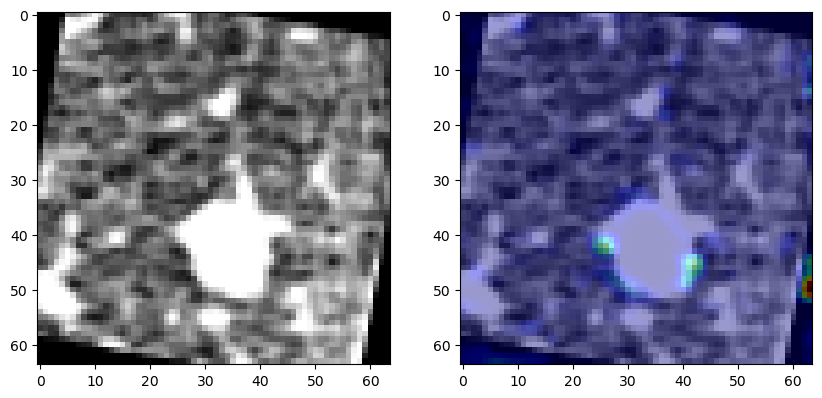

################## Bayesian CNN ##################
Prediction: 1 - 99.37%
Std dev: 0.0 - 1.03%
Prediction correct: True


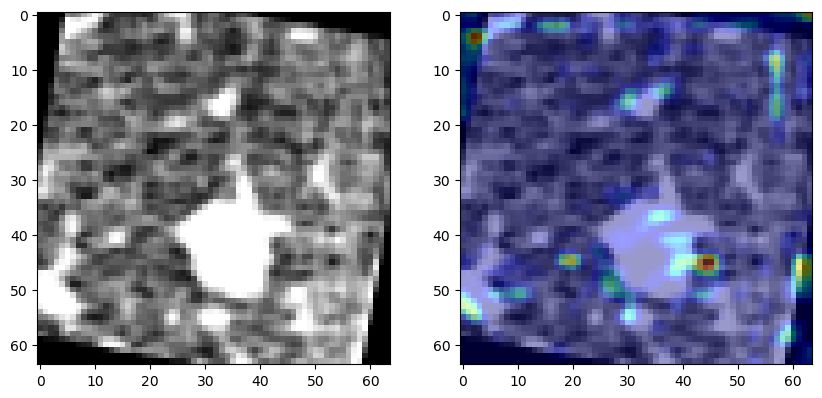

In [44]:
img_num = 3
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Bayesian CNN ##################')
compute_gradcam_bayesian(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)

################## Traditional CNN ##################
Prediction: 1 - 99.58%
Ground truth: 1


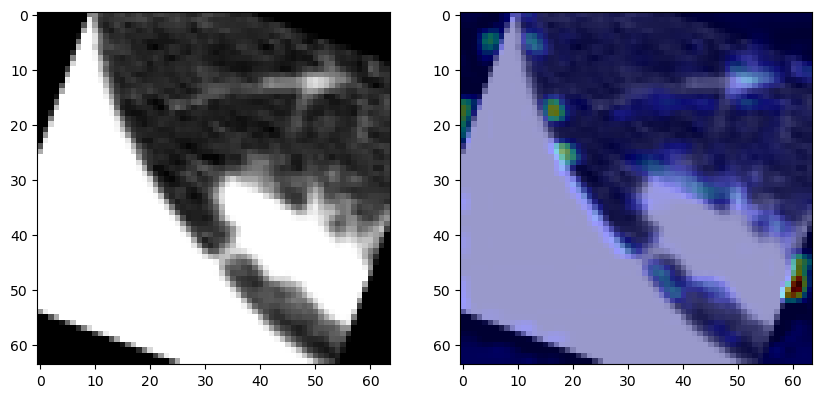

################## Bayesian CNN ##################
Prediction: 1 - 93.87%
Std dev: 0.0 - 6.69%
Prediction correct: True


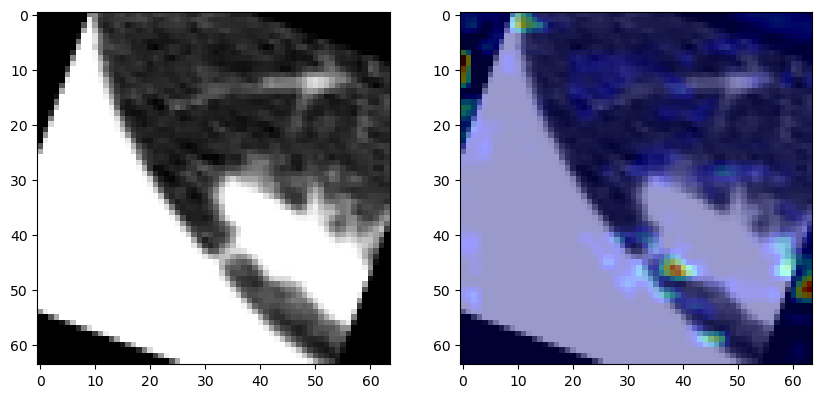

In [45]:
img_num = 10
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Bayesian CNN ##################')
compute_gradcam_bayesian(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)

In the above example we can see how in a wrong prediction with high accuracy the standard deviation can help to not trust the prediction blindly. Since the standard deviation is very big, the prediction cannot be trusted blindly.

################## Traditional CNN ##################
Prediction: 1 - 99.09%
Ground truth: 0


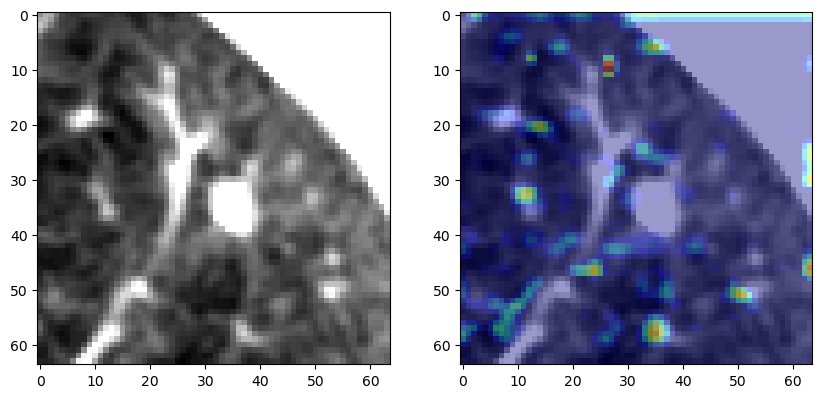

################## Bayesian CNN ##################
Prediction: 1 - 81.76%
Std dev: 0.34 - 12.37%
Prediction correct: False


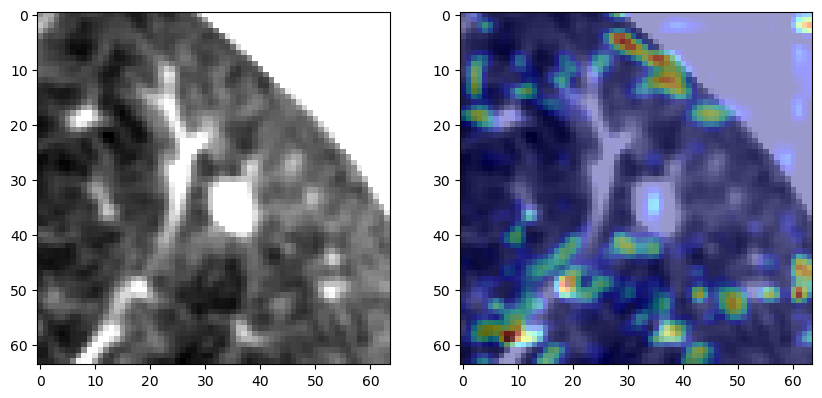

In [46]:
img_num = 27
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Bayesian CNN ##################')
compute_gradcam_bayesian(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)

In the above example we can see how in a wrong prediction with high accuracy the standard deviation can help to not trust the prediction blindly. Since the standard deviation is very big, the prediction cannot be trusted blindly.

# Eliminate info from image and see model behaviour change

Now, let’s see how this model handles out-of-distribution data. Imagine we deploy this model to recognize digits, but users sometimes fail to write down the entire digit. What happens when users do not write down the entire digit? We can get an answer to this question by gradually removing more and more information from a digit, and seeing how our model handles the perturbed inputs. We can define our function to remove signal as follows:

In [47]:
def remove_row(img: np.ndarray, row_index: int) -> np.ndarray:  
    img = img.copy()  
    img[:, :row_index, :] = 0  # Set the specified slice to black
    return img

def remove_column(img: np.ndarray, row_column: int) -> np.ndarray:  
    img = img.copy()  
    img[:, :, :row_column] = 0  # Set the specified slice to black
    return img

In [48]:
list(range(0, 60, 4))

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56]

And then we perturb our images:

In [49]:
def get_imgs_prgs_rem(img, column=False, row=True):
    imgs = []
    img_perturbed = img
    for i in range(0, 60, 4): 
        if row:
            # Set to black until row i
            img_perturbed = remove_row(img_perturbed, i)
        if column:
            # Set to black until column i
            img_perturbed = remove_column(img_perturbed, i)  
        imgs.append(img_perturbed)  
        if img_perturbed.sum() == 0:  
            break
    return imgs

In [50]:
def plot_predictions_traditional(softmax_predictions, imgs, alpha=0.4):
    plt.figure(figsize=(10, 10))  
    bbox_dict = dict(fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0)
    middle_slice = int(len(imgs[0])/2)
    for i in range(len(imgs)):  
        # Initialize subplot for this image
        ax = plt.subplot(5, 5, i + 1)  
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        
        # Compute heatmap
        heatmap_upscaled, img_plot = compute_gradcam(img=imgs[i], label=0, display=False)
        # Create ploat of image with superposed heatmap
        img0 = ax.imshow(np.squeeze(img_plot[middle_slice, :, :]), cmap='gray')
        img1 = ax.imshow(np.squeeze(heatmap_upscaled[middle_slice, :, :]), cmap='jet', alpha=alpha, extent=img0.get_extent())
        
        # Add prediction and confidence
        prediction = softmax_predictions[i].numpy().max()  
        label = np.argmax(softmax_predictions[i]) 
        plt.xlabel(f"{label} - {prediction:.2%}")  
        plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
    plt.show()

In [51]:
def plot_predictions_dropout(predictions, imgs, alpha=0.4):
    plt.figure(figsize=(10, 10))  
    bbox_dict = dict(fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0)
    middle_slice = int(len(imgs[0])/2)
    for i in range(len(imgs)):  
        ax = plt.subplot(5, 5, i + 1)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        
        #plt.imshow(imgs[i][middle_slice], cmap="gray")
        heatmap_upscaled, img_plot = compute_gradcam_dropout(img=imgs[i], label=0, display=False)
        img0 = ax.imshow(np.squeeze(img_plot[middle_slice, :, :]), cmap='gray')
        img1 = ax.imshow(np.squeeze(heatmap_upscaled[middle_slice, :, :]), cmap='jet', alpha=alpha, extent=img0.get_extent())
        
        prediction = predictions[i].max()  
        label = np.argmax(predictions[i])  
        plt.xlabel(f"{label} - {prediction:.2%}")  
        plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
    plt.show()

In [52]:
def plot_predictions_bayesian(imgs, alpha=0.4):
    plt.figure(figsize=(10, 10))  
    bbox_dict = dict(fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0)
    middle_slice = int(len(imgs[0])/2)
    for i in range(len(imgs)):  
        ax = plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(hspace=.3)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        
        #plt.imshow(imgs[i][middle_slice], cmap="gray")
        heatmap_upscaled, img_plot, pred, pred_prob, pred_std, pred_prob_std  = compute_gradcam_bayesian(img=imgs[i], label=0, display=False)
        img0 = ax.imshow(np.squeeze(img_plot[middle_slice, :, :]), cmap='gray')
        img1 = ax.imshow(np.squeeze(heatmap_upscaled[middle_slice, :, :]), cmap='jet', alpha=alpha, extent=img0.get_extent())
         
        plt.xlabel(f"{pred} - {pred_prob:.2%}\n{pred_std:.2} - {pred_prob_std:.3}")  
        plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
    plt.show()

In [53]:
def plot_predictions(img_num):
    print(f'Ground truth is: {test_labels[img_num]}')

    print('################## Traditional CNN ##################')
    imgs = get_imgs_prgs_rem(test_images[img_num], column=True, row=True)
    softmax_predictions = tf.nn.softmax(model(np.expand_dims(imgs, -1)), axis=1)
    plot_predictions_traditional(softmax_predictions, imgs)

    print('################## Dropout CNN ##################')
    imgs = get_imgs_prgs_rem(test_images[img_num], column=True, row=True)
    predictions_mean = predictions_dropout(imgs)
    plot_predictions_dropout(predictions_mean, imgs)
    
    print('################## Bayesian CNN ##################')
    imgs = get_imgs_prgs_rem(test_images[img_num], column=True, row=True)
    plot_predictions_bayesian(imgs)

Ground truth is: 1
################## Traditional CNN ##################


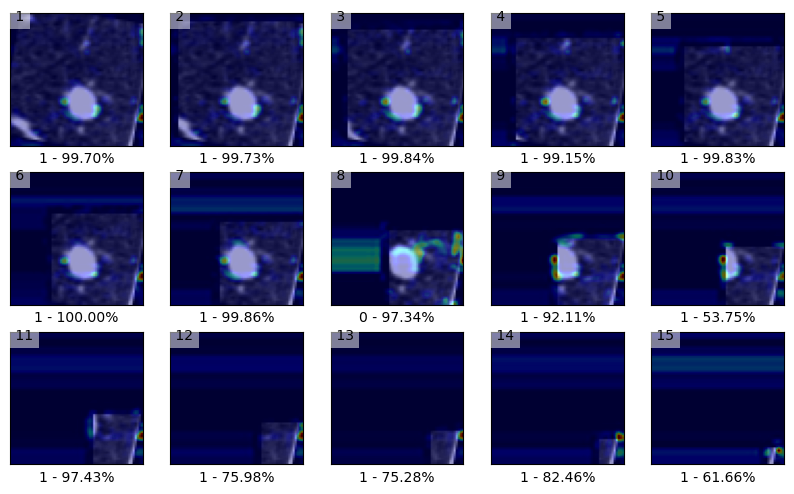

################## Dropout CNN ##################


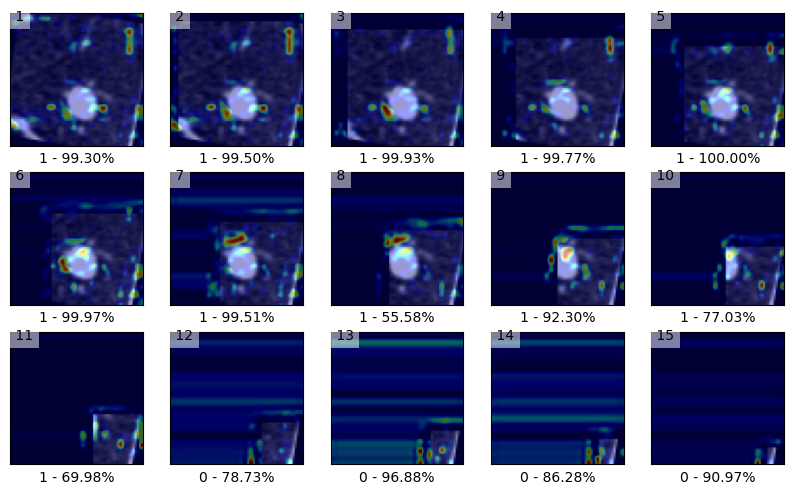

################## Bayesian CNN ##################


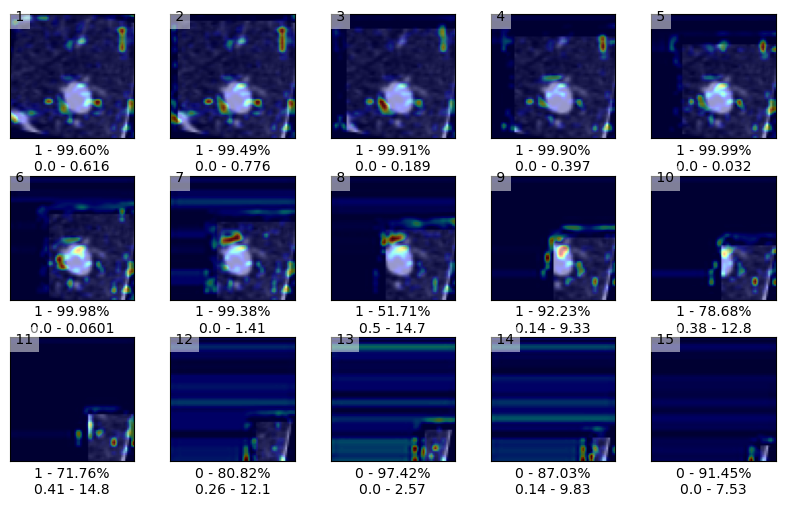

In [54]:
plot_predictions(img_num=3)

Ground truth is: 1
################## Traditional CNN ##################


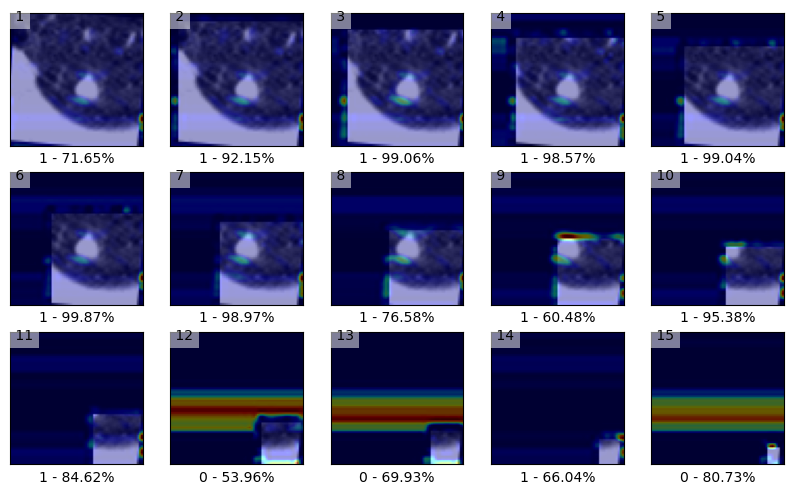

################## Dropout CNN ##################


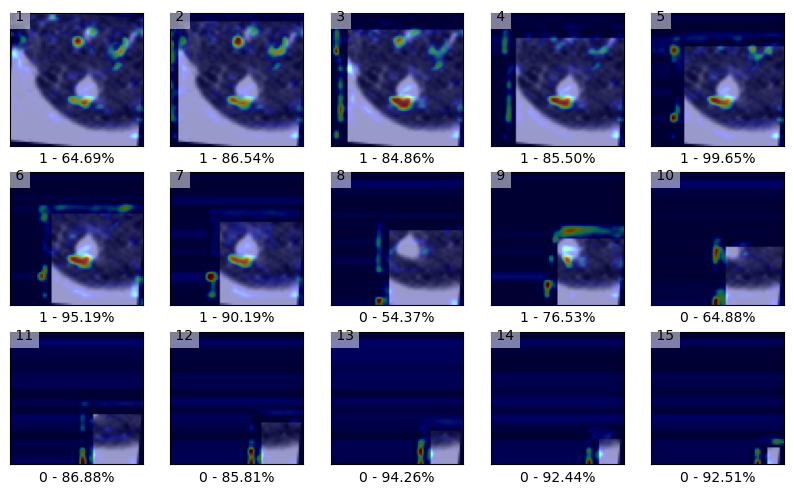

################## Bayesian CNN ##################


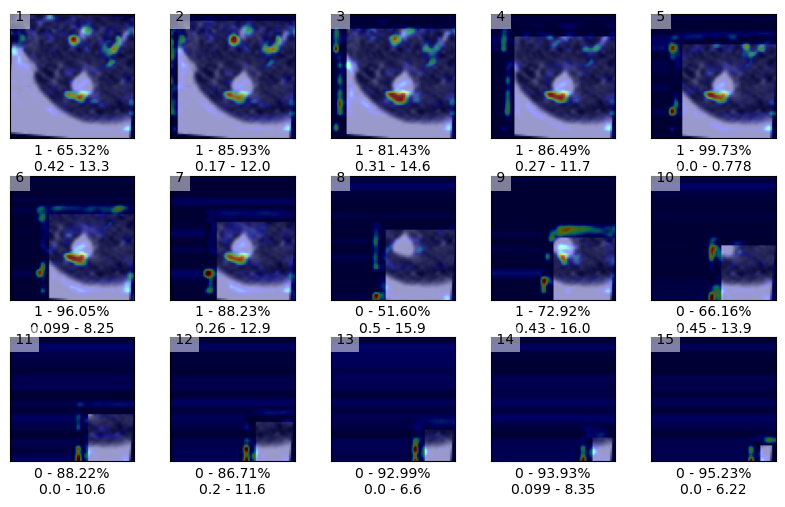

In [55]:
plot_predictions(img_num=1)

Ground truth is: 1
################## Traditional CNN ##################


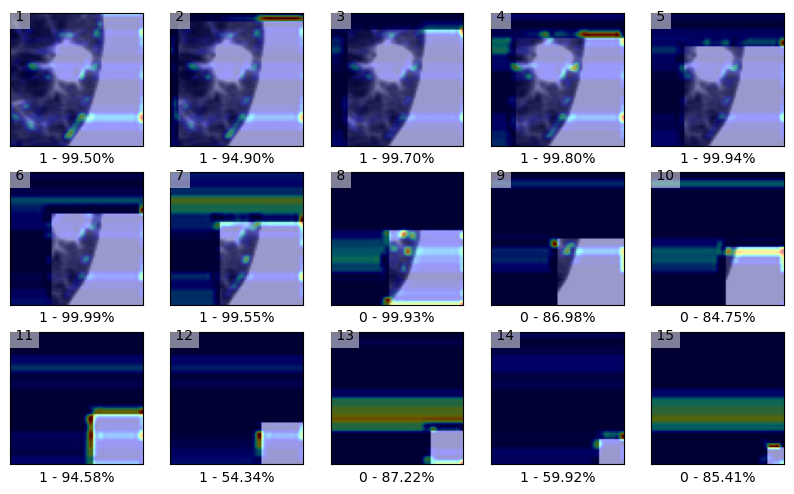

################## Dropout CNN ##################


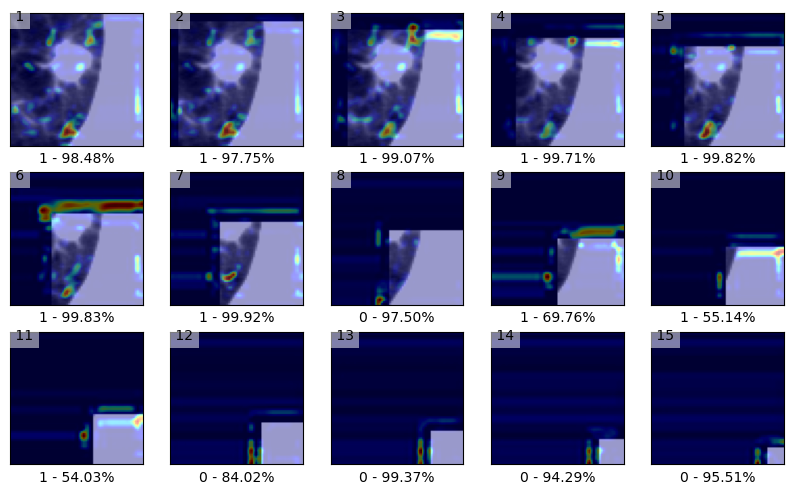

################## Bayesian CNN ##################


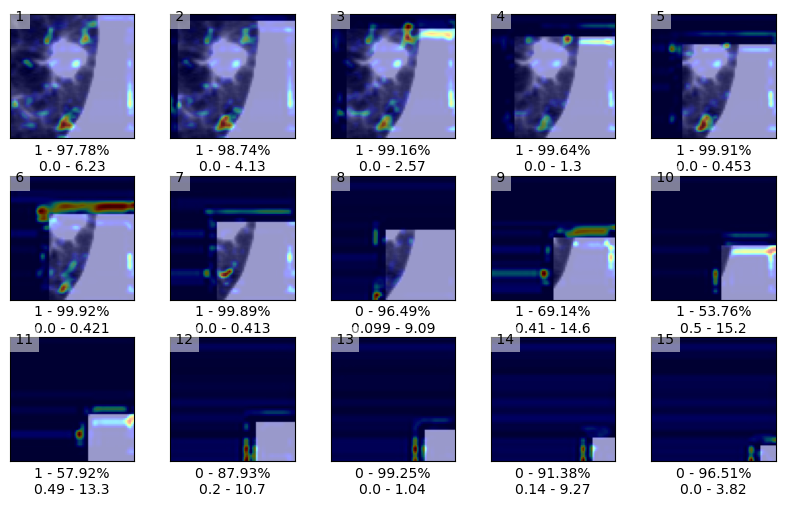

In [56]:
plot_predictions(img_num=4)

Image 8 shows a relatively high prediction probability (79%), but:

- the prediction std is almost 3 times higher than the median for correct predictions
- The prediction std is 12,5%, also 3 times higher than the median for correct predictions

Therefore, is concluded that the image 8 prediction cannot be trusted even if it has a high probability.

When observing the ground truth it is indeed confirmed that the prediction was incorrect.